In [1]:
from cvxpy import *
from numpy import array
import numpy as np
from matplotlib import pyplot as plt
from mlxtend.data import loadlocal_mnist
import time


In [2]:
def plotting(x,y,a,b,t):
    # Takes in a set of datapoints x and y for two clusters,
    #  the hyperplane separating them in the form a'x -b = 0,
    #  and a slab half-width t
    plt.ylim([-10,10])
    plt.xlim([-10,10])
    plt.scatter(x[:,0], x[:,1], c='b', marker='o')
    plt.scatter(y[:,0], y[:,1], c='r', marker='x')
    d1_min = np.min([x[:,0]])
    d1_min1 = np.min([y[:,0]])
    if d1_min > d1_min1:
        d1_min=d1_min1
    d1_max = np.max([x[:,0]])
    d1_max1 = np.max([y[:,0]])
    if d1_max < d1_max1:
        d1_max=d1_max1
    # Line form: (-a[0] * x - b ) / a[1]
    d2_atD1min = (-a[0]*d1_min + b ) / a[1]
    d2_atD1max = (-a[0]*d1_max + b ) / a[1]

    sup_up_atD1min = (-a[0]*d1_min + b + t ) / a[1]
    sup_up_atD1max = (-a[0]*d1_max + b + t ) / a[1]
    sup_dn_atD1min = (-a[0]*d1_min + b - t ) / a[1]
    sup_dn_atD1max = (-a[0]*d1_max + b - t ) / a[1]

    # Plot the Lines
    plt.plot([d1_min,d1_max],[d2_atD1min,d2_atD1max],color='black')
    plt.plot([d1_min,d1_max],[sup_up_atD1min,sup_up_atD1max],'--',color='gray')
    plt.plot([d1_min,d1_max],[sup_dn_atD1min,sup_dn_atD1max],'--',color='gray')
##########################
def readdata():
    filename= 'ToyData.txt'
    xp=[]
    xn=[]
    yp=[]
    yn=[]
    with open(filename) as f:
        line = f.readline()
        while line:
            line = f.readline().rstrip('\n').split()
            if line:
                line[0] = int(line[0])
                line[1] = int(line[1])
                line[2] = int(line[2])
                if line[2]>0:
                    xp.append([line[0],line[1]])
                    yp.append([line[2]])
                else:
                    xn.append([line[0],line[1]])
                    yn.append([line[2]])
    return xp,yp,xn,yn


In [3]:
##########
#Optimization
##########
def test(c,xp,xn,yp,yn,m,n,p,pw,cross,tx,ty):
    w = Variable(d)
    b = Variable()
    zipp = Variable(m)
    zin = Variable(n)
    C = Parameter()
    C.value = c
    xp=np.array(xp)
    yp=np.array(yp)
    xn=np.array(xn)
    yn=np.array(yn)
    obj = Minimize((norm(w,2)**2/2) + C*np.ones(m)*zipp + C*np.ones(n)*zin)

    constraints = [w.T * xp[i] + b >= 1 - zipp[i] for i in range(m)]
    constraints.extend([w.T * xn[i] + b <= -1 + zin[i] for i in range(n)])
    constraints.extend([zipp[i] >= 0  for i in range(m)])
    constraints.extend([zin[i] >= 0  for i in range(n)])
    #print("Solving...")
    prob = Problem(obj, constraints)
    prob.solve(qcp=True)
    w = w.value
    normw=np.linalg.norm(w)
    thi=np.arctan(w[1]/w[0])
    b = b.value
    c = C.value
    #print("Solved!")
    error = 0
    #print("wx + b >=0:")
    for i in range(m):
        x = np.dot(w.T,xp[i])+b
        #print(x)
        if x<0:
            error+=1
    #print("wx + b < 0:")
    for i in range(n):
        x = np.dot(w.T,xn[i])+b
        #print(x)
        if x>=0:
            error+=1
    
    if pw>0:
        print("C=", c)
        print("w vector=",w)
        print("margin 1/||w||=",1/normw)
        print("support vector(dual):",constraints[0].dual_value)
        print("support vector(dual):",constraints[1].dual_value)
        
    if p>0:
        plotting(xp,xn,w,b,1)
        plt.show()
    if cross>0:
        x = np.dot(w.T,tx)+b
        #print(x)
        if x>0:
            if ty[0]<0:
                return 1
            else:
                return 0
        if x<0:
            if ty[0]>0:
                return 1
            else:
                return 0
    else:
        print("Misclassification Error:",error,"/",m+n,"= {:.3f} %\n".format(error/(m+n)*100))
    return error
###########
def crossvalid(xp,yp,m,n,p,pw):
    error=0

    for i in range(m):
        xpp=list(xp)
        ypp=list(yp)
        testdatax=xpp[i]
        testdatay=ypp[i]
        del xpp[i]
        del ypp[i]
        error = error + test(1,xpp,xn,ypp,yn,m-1,n,p,pw,1,testdatax,testdatay)
        #print("error=",error)
    for i in range(n):
        xnn=list(xn)
        ynn=list(yn)
        testdatax=xnn[i]
        testdatay=ynn[i]
        del xnn[i]
        del ynn[i]
        error = error + test(1,xp,xnn,yp,ynn,m,n-1,p,pw,1,testdatax,testdatay)
        #print("error=",error)
    print("Cross Validation Error: {:.3f} %".format(error/(m+n)*100))
    

In [4]:
d = 2 #dimension
xp=[]
xn=[]
yp=[]
yn=[]
m=7
n=8
xp,yp,xn,yn=readdata()
crossvalid(xp,yp,m,n,0,0)

Cross Validation Error: 33.333 %


C= 1
w vector= [ 1.00000000e+00 -1.42318515e-10]
margin 1/||w||= 0.9999999998925835
support vector(dual): 1.0000000000651883
support vector(dual): 0.8772972446274951


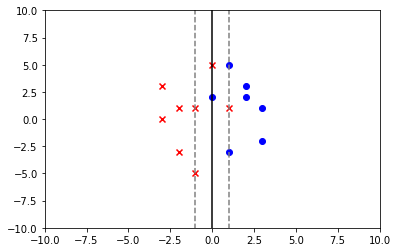

Misclassification Error: 2 / 15 = 13.333 %

C= 100000
w vector= [ 1.00002155e+00 -3.11365878e-10]
margin 1/||w||= 0.9999784491288226
support vector(dual): 99999.99999237097
support vector(dual): 87500.0507211019


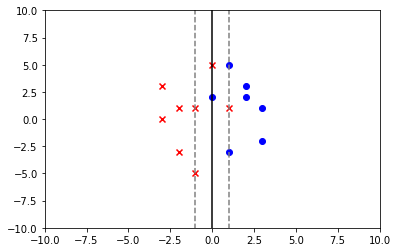

Misclassification Error: 2 / 15 = 13.333 %



2

In [5]:
d = 2 #dimension
xp=[]
xn=[]
yp=[]
yn=[]

xp,yp,xn,yn=readdata()
test(1,xp,xn,yp,yn,7,8,1,1,0,0,0)
test(100000,xp,xn,yp,yn,7,8,1,1,0,0,0)

In [6]:

d = 784

(X_train, Y_train) = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')
(X_test, Y_test) = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte', 
        labels_path='t10k-labels.idx1-ubyte')
train_filter = np.where((Y_train == 0 ) | (Y_train == 1))
(X_train, Y_train) = X_train[train_filter], Y_train[train_filter]
print('labels: %s' % np.unique(Y_train))
total = np.bincount(Y_train)
t0,t1 = total[0],total[1]
print('Class distribution:0s:',t0,"1s:",t1 )
xp = X_train[:5923]
xn = X_train[-6742:]
yp = Y_train[:5923]
yn = Y_train[-6742:]
start = time.time()
test(1,xp,xn,yp,yn,t0,t1,0,0,0,0,0)
end = time.time()
print("Time elapsed: {:.3f} ".format(end - start),"s")


labels: [0 1]
Class distribution:0s: 5923 1s: 6742


C:\Users\h1247\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Misclassification Error: 5128 / 12665 = 40.490 %

Time elapsed: 93.123  s


In [7]:
def re_test(xp,yp,xn,yn,d,n,p):
    xpp = list(xp)
    ypp = list(yp)
    xpp.extend(xn)
    ypp.extend(yn)
    xppx= [item[0] for item in xpp]
    xppy= [item[1] for item in xpp]
    xppx = np.array(xppx)
    xppy = np.array(xppy)
    ypp = np.array(ypp)

    A = Variable()
    b = Variable()
    obj = 0
    for i in range(n):
        obj += (A * xppx[i] + b - xppy[i]) ** 2
    prob = Problem(Minimize(obj),[])
    prob.solve()
    
    """for i in range(n):
        print(A.value * xppx[i] + b.value - xppy[i])"""
    if p>0:
        plt.scatter(xppx,xppy)
        plt.plot(xppx, (A.value)*xppx + b.value,color='black')
    return(xppx,A.value,b.value)
#################################
def re_crossvalid(d,n):
    error=0
    xp,yp,xn,yn=readdata()
    for i in range(len(xp)):
        xpp=list(xp)
        ypp=list(yp)
        del xpp[i]
        del ypp[i]
        x,A,b=re_test(xp,yp,xn,yn,d,n-1,0)
        print(A * xp[i][0] + b - xp[i][1])
    for i in range(len(xn)):
        xnn=list(xn)
        ynn=list(yn)
        del xnn[i]
        del ynn[i]
        x,A,b=re_test(xp,yp,xn,yn,d,n-1,0)
        #print("error=",error)
    print("Cross Validation Error: {:.3f} %".format(error/(len(xp)+len(xn))*100))

(array([ 0,  1,  1,  2,  2,  3,  3, -1, -2, -2, -3, -3, -1,  1,  0]),
 array(0.14519906),
 array(0.7236534))

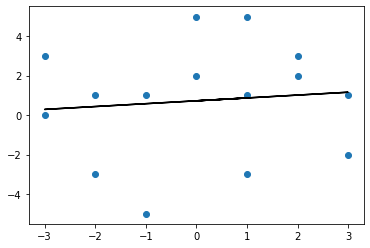

In [8]:
xp,yp,xn,yn=readdata()
d = 2
n = 15
re_test(xp,yp,xn,yn,d,n,1)

In [9]:
re_crossvalid(d,n)

-1.5821831869510665
-4.431618569636136
3.5683814303638646
-1.2810539523212046
-2.2810539523212046
-0.1304893350062737
2.8695106649937263
Cross Validation Error: 0.000 %
